**Team 4**
*   Karthikeya Reddy Bommareddy(1002128577)
*   Urekha Kulala(1002164102)
*   Vaishnavi Pothuri(1002120548)

Google colab link : https://colab.research.google.com/drive/153bBf2rj75bHAoM_dbTmmDMS1keITycU?usp=sharing#scrollTo=tvcyWaq28aXW

In [ ]:
pip install requests

In [ ]:
import os
import zipfile
import requests

# URLs for the dataset and annotations
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
annotations_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# File paths for storing the downloaded data
output_directory = "./Flickr8k"
dataset_zip_path = os.path.join(output_directory, "Flickr8k_Dataset.zip")
annotations_zip_path = os.path.join(output_directory, "Flickr8k_text.zip")

# Folder for unzipping the files
extraction_folder = os.path.join(output_directory, "Extracted_Content")

# Ensure directories for downloads and extraction exist
os.makedirs(output_directory, exist_ok=True)
os.makedirs(extraction_folder, exist_ok=True)

# Function to fetch a file from a URL and save it locally
def fetch_and_save_file(url, save_path):
    print(f"Fetching data from {url}...")
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=128):
            file.write(chunk)
    print(f"Saved file at {save_path}")

# Function to extract contents of a ZIP file
def extract_zip_file(zip_file_path, destination_folder):
    print(f"Unzipping {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_archive:
        zip_archive.extractall(destination_folder)
    print(f"Contents extracted to {destination_folder}")

# Download both the image dataset and the accompanying annotations
fetch_and_save_file(dataset_url, dataset_zip_path)
fetch_and_save_file(annotations_url, annotations_zip_path)

# Unzip the downloaded files into respective folders
extract_zip_file(dataset_zip_path, os.path.join(extraction_folder, "Images"))
extract_zip_file(annotations_zip_path, os.path.join(extraction_folder, "Annotations"))

print("The Flickr8k dataset and annotations have been successfully downloaded and unpacked.")

Fetching data from https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip...
Saved file at ./Flickr8k/Flickr8k_Dataset.zip
Fetching data from https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip...
Saved file at ./Flickr8k/Flickr8k_text.zip
Unzipping ./Flickr8k/Flickr8k_Dataset.zip...
Contents extracted to ./Flickr8k/Extracted_Content/Images
Unzipping ./Flickr8k/Flickr8k_text.zip...
Contents extracted to ./Flickr8k/Extracted_Content/Annotations
The Flickr8k dataset and annotations have been successfully downloaded and unpacked.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import string
import pickle
import zipfile
import requests

# Defining the file paths
image_folder_path = "/content/Flickr8k/Extracted_Content/Images/Flicker8k_Dataset/"
captions_file_path = "/content/Flickr8k/Extracted_Content/Annotations/Flickr8k.token.txt"

# Function to load and clean captions
def parse_captions(file_path):
    caption_mapping = {}
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split("\t")  # Captions are tab-separated
            img_id, caption = parts[0], parts[1]
            img_id = img_id.split(".")[0]  # Remove file extension
            cleaned_caption = "start " + caption.lower().translate(str.maketrans("", "", string.punctuation)) + " end"
            caption_mapping.setdefault(img_id, []).append(cleaned_caption)
    return caption_mapping

image_captions = parse_captions(captions_file_path)

# Limit to 100 images for quick testing
subset_images = list(image_captions.keys())[:100]
image_captions = {k: image_captions[k] for k in subset_images}

# Extract image features using VGG16
def extract_image_features(image_folder, img_ids):
    vgg_model = VGG16(weights="imagenet", include_top=False)
    feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-1].output)
    img_features = {}
    for img_id in img_ids:
        img_path = os.path.join(image_folder, img_id + ".jpg")
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        img_features[img_id] = feature_extractor.predict(img_array, verbose=0)
    return img_features

image_features = extract_image_features(image_folder_path, subset_images)

# Save image features for reuse
with open("image_features.pkl", "wb") as file:
    pickle.dump(image_features, file)

# Create tokenizer for captions
all_captions = [caption for captions in image_captions.values() for caption in captions]
caption_tokenizer = Tokenizer()
caption_tokenizer.fit_on_texts(all_captions)
vocabulary_size = len(caption_tokenizer.word_index) + 1

# Save the tokenizer
with open("tokenizer.pkl", "wb") as file:
    pickle.dump(caption_tokenizer, file)

print("Tokenizer saved as 'tokenizer.pkl'.")

# Prepare training data sequences
max_caption_length = max(len(caption.split()) for caption in all_captions)

def prepare_training_data(tokenizer, caption_mapping, img_features, max_length):
    img_input, seq_input, target_output = [], [], []
    for img_id, captions in caption_mapping.items():
        for caption in captions:
            encoded_seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(encoded_seq)):
                input_seq, output_seq = encoded_seq[:i], encoded_seq[i]
                input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                output_seq = to_categorical([output_seq], num_classes=vocabulary_size)[0]
                img_input.append(img_features[img_id][0])
                seq_input.append(input_seq)
                target_output.append(output_seq)
    return np.array(img_input), np.array(seq_input), np.array(target_output)

img_features_array, seq_input_array, target_array = prepare_training_data(
    caption_tokenizer, image_captions, image_features, max_caption_length
)

# Define the caption generation model(Encoder-decoder model)
def build_captioning_model(vocab_size, max_length):
    # Image feature extractor input
    img_input_layer = Input(shape=(7, 7, 512))
    img_features = tf.keras.layers.GlobalAveragePooling2D()(img_input_layer)
    img_dense = Dense(256, activation="relu")(img_features)

    # Sequence input
    seq_input_layer = Input(shape=(max_length,))
    seq_embedding = Embedding(vocab_size, 256, mask_zero=True)(seq_input_layer)
    seq_lstm = LSTM(256)(seq_embedding)

    # decoder
    merged = Add()([img_dense, seq_lstm])
    dense_layer = Dense(256, activation="relu")(merged)
    output_layer = Dense(vocab_size, activation="softmax")(dense_layer)

    # Compiling the model
    caption_model = Model(inputs=[img_input_layer, seq_input_layer], outputs=output_layer)
    caption_model.compile(loss="categorical_crossentropy", optimizer="adam")
    return caption_model

caption_model = build_captioning_model(vocabulary_size, max_caption_length)

# Train the model
model_checkpoint = ModelCheckpoint("model.keras", save_best_only=True, monitor="loss", mode="min")
training_history = caption_model.fit(
    [img_features_array, seq_input_array], target_array, epochs=10, batch_size=32, callbacks=[model_checkpoint]
)

Tokenizer saved as 'tokenizer.pkl'.
Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - loss: 5.6207
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - loss: 3.9709
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - loss: 3.1657
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - loss: 2.6531
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - loss: 2.2067
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - loss: 1.9617
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - loss: 1.7733
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - loss: 1.5952
Epoch 9/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 162ms/step - loss: 1.4170
Epoch 10/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - loss: 1.3629



Caption generation step by step:
Initial text sequence: start 
Step 1:
  Input Sequence: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]
  Predicted Index of the given input: 175
  Predicted Word of the given input: there
  Predicted Probability value: 0.3822
  Loss value: 0.9619
  Confidence value: 38.22%
Step 2:
  Input Sequence: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3 175]]
  Predicted Index of the given input: 8
  Predicted Word of the given input: is
  Predicted Probability value: 0.3849
  Loss value: 0.9546
  Confidence value: 38.49%
Step 3:
  Input Sequence: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   3 175   8]]
  Predicted Index of the given input: 18
  Predicted Word of the given input: girl
  Predicted Probability value: 0.6733
  Loss value: 0.3956
  Confidence value: 67.33%
Step 4:
  Input Sequence: [[  0   0   0   0   0   0   0 

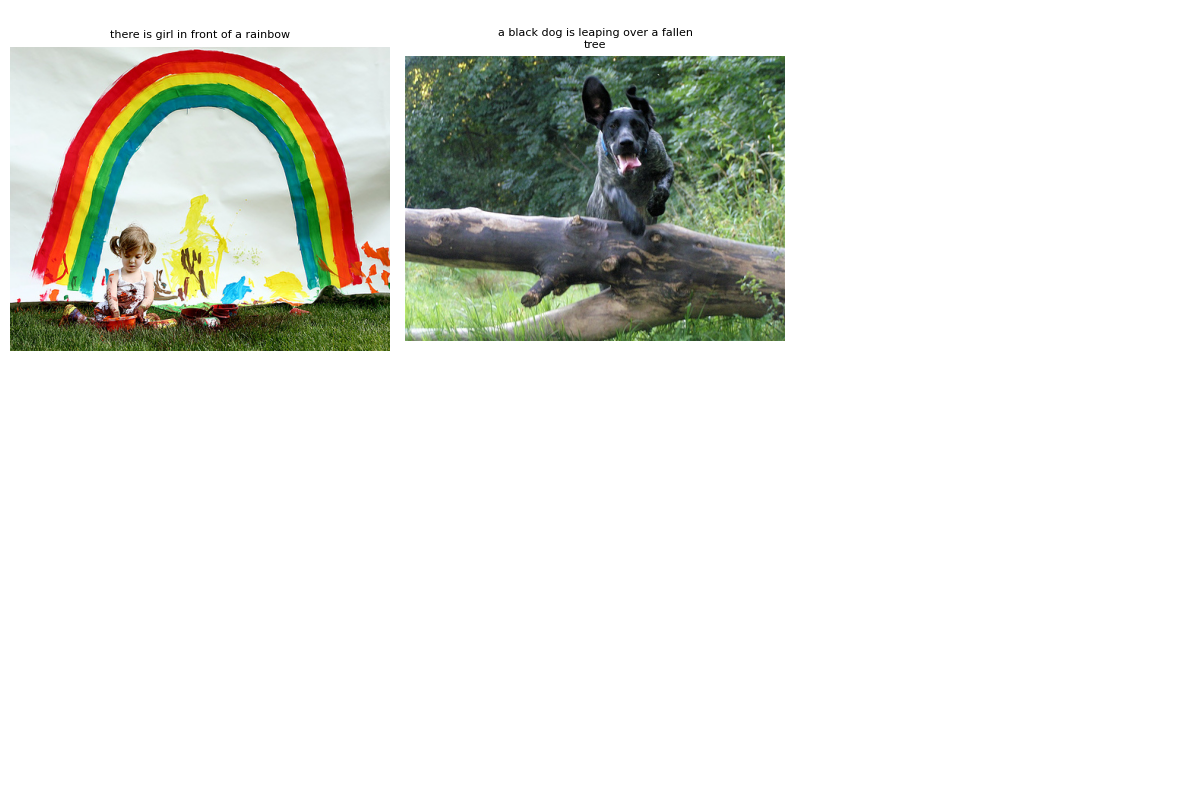

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import textwrap

# Load the pre-trained VGG16 model for image feature extraction
vgg16_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

# Configure the model to output 3D feature maps (7x7x512)
feature_extractor_model = tf.keras.models.Model(inputs=vgg16_model.input, outputs=vgg16_model.output)

caption_generator_model = load_model("model.keras")

# Generate captions step by step for debugging
def generate_caption_with_debugging(generator_model, tokenizer, feature_maps, max_seq_length):
    caption_text = "start "
    print("\nCaption generation step by step:")
    print("Initial text sequence:", caption_text)

    for step in range(max_seq_length):
        # Convert the caption text to a sequence of integers
        sequence = tokenizer.texts_to_sequences([caption_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_seq_length)

        # Predict the next word in the sequence
        prediction = generator_model.predict([feature_maps, sequence], verbose=0)
        predicted_index = np.argmax(prediction)  # Find the index of the most probable word
        predicted_word = tokenizer.index_word.get(predicted_index, None)  # Get the word from the index

        # Calculate probability, loss, and confidence for the predicted word
        predicted_probability = prediction[0][predicted_index]  # Probability of the predicted word
        cross_entropy_loss = -np.log(predicted_probability) if predicted_probability > 0 else float('inf')
        confidence = predicted_probability * 100  # Confidence as percentage

        # Log details of the current step
        print(f"Step {step + 1}:")
        print(f"  Input Sequence: {sequence}")
        print(f"  Predicted Index of the given input: {predicted_index}")
        print(f"  Predicted Word of the given input: {predicted_word}")
        print(f"  Predicted Probability value: {predicted_probability:.4f}")
        print(f"  Loss value: {cross_entropy_loss:.4f}")
        print(f"  Confidence value: {confidence:.2f}%")

        # Stop generating if the 'end' token is predicted or no valid word is found
        if predicted_word is None or predicted_word == " end":
            print("Prediction ended with  end or no valid word.")
            break

        # Avoid infinite loops caused by repeated predictions
        if len(caption_text.split()) > 1 and predicted_word == caption_text.split()[-1]:
            print("Stopping due to consecutive repetition.")
            break

        # Append the predicted word to the caption
        caption_text += " " + predicted_word

    # Clean up the final caption text
    final_caption = caption_text.replace("start ", "").strip()
    final_caption = final_caption.replace(" end", "")  # Explicitly remove the 'end' token
    print("Final Caption:", final_caption)
    return final_caption

# Extract features from an input image
def extract_features_from_image(image_path, model):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = tf.keras.applications.vgg16.preprocess_input(image_array)
    feature_maps = model.predict(image_array, verbose=0)  # Get 3D feature maps
    return feature_maps

# Remove redundant words from captions
def refine_caption_text(raw_caption):
    words = raw_caption.split()
    refined_words = []
    for i, word in enumerate(words):
        if i == 0 or word != words[i - 1]:  # Include the word if it isn't a duplicate of the previous word
            refined_words.append(word)
    return " ".join(refined_words)

# Load the tokenizer from the pickle file
with open("tokenizer.pkl", "rb") as file:
    text_tokenizer = pickle.load(file)

# Define the maximum sequence length for captions
max_sequence_length = 28  # Should match the training configuration

# List of image paths to test the model
test_images = [
    "/content/Flickr8k/Extracted_Content/Images/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg",
    "/content/Flickr8k/Extracted_Content/Images/Flicker8k_Dataset/1015584366_dfcec3c85a.jpg",
]

# Display images with generated captions
figure, axes_grid = plt.subplots(2, 3, figsize=(12, 8))  # Create a grid layout for displaying images
axes_grid = axes_grid.flatten()  # Flatten the grid for easier indexing

for idx, image_path in enumerate(test_images):
    if idx >= len(axes_grid):  # Stop if there are more images than subplots
        break

    # Extract features for the current image
    image_features = extract_features_from_image(image_path, feature_extractor_model)

    # Generate a raw caption for the image
    raw_caption = generate_caption_with_debugging(caption_generator_model, text_tokenizer, image_features, max_sequence_length)

    # Clean and refine the generated caption
    refined_caption = refine_caption_text(raw_caption)

    # Wrap the caption for better display
    caption_wrapped = "\n".join(textwrap.wrap(refined_caption, width=40))

    # Load and display the current image
    image = load_img(image_path)
    subplot = axes_grid[idx]  # Select the appropriate subplot
    subplot.imshow(image)
    subplot.axis('off')  # Hide axes
    subplot.set_title(caption_wrapped, fontsize=8)  # Set caption as the title

# Disable unused subplots
for subplot in axes_grid[len(test_images):]:
    subplot.axis('off')

plt.tight_layout()  # Adjust layout to fit content
plt.show()